In [1]:

import torch
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset, DataLoader
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

from src.data.dataset import PatchFromH5Dataset, stratified_split, plot_class_distributions
from src.rl.train import ModelTrainer, TrainingArguments
from src.rl.modelling import ViT_UCB_Pruning


/home/vcivale/UNI_UCB2/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
IMG_SIZE = 224
TRAIN_BATCH_SIZE = 8
NUM_EPOCHS = 50

PRUNING_RATIO = 0.01

DEVICE = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [3]:
dataset = PatchFromH5Dataset(
    h5_dir='/equilibrium/datasets/TCGA-histological-data/hest/patches/patches/',
    transform=transforms.Compose([
        transforms.Resize(IMG_SIZE),
        transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),])
)

In [4]:
labels = dataset.labels

In [5]:
# Crea un DataFrame con indici e label
df = pd.DataFrame({
    "index": np.arange(len(labels)),
    "label": labels
})

# Trova il numero di elementi della classe minoritaria
min_count = df["label"].value_counts().min()

# Per ogni classe, seleziona min_count elementi a caso
undersampled_df = (
    df.groupby("label", group_keys=False)
      .apply(lambda x: x.sample(n=min_count, random_state=42)).reset_index(drop=True)
)

# Mischia gli indici
undersampled_indices = undersampled_df["index"].sample(frac=1, random_state=42).tolist()


/tmp/ipykernel_66422/3282357617.py:13: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=min_count, random_state=42)).reset_index(drop=True)


In [6]:
undersampled_labels = [labels[i] for i in undersampled_indices]

trainval_idx, test_idx = train_test_split(
    undersampled_indices,
    test_size=0.3,
    stratify=undersampled_labels,
    random_state=42
)

# Ottieni i label corrispondenti per il secondo split
trainval_labels = [labels[i] for i in trainval_idx]

# Split: train vs val
train_idx, val_idx = train_test_split(
    trainval_idx,
    test_size=0.3,
    stratify=trainval_labels,
    random_state=42
)

# Crea i subset
train_dataset = Subset(dataset, train_idx)
val_dataset   = Subset(dataset, val_idx)
test_dataset  = Subset(dataset, test_idx)

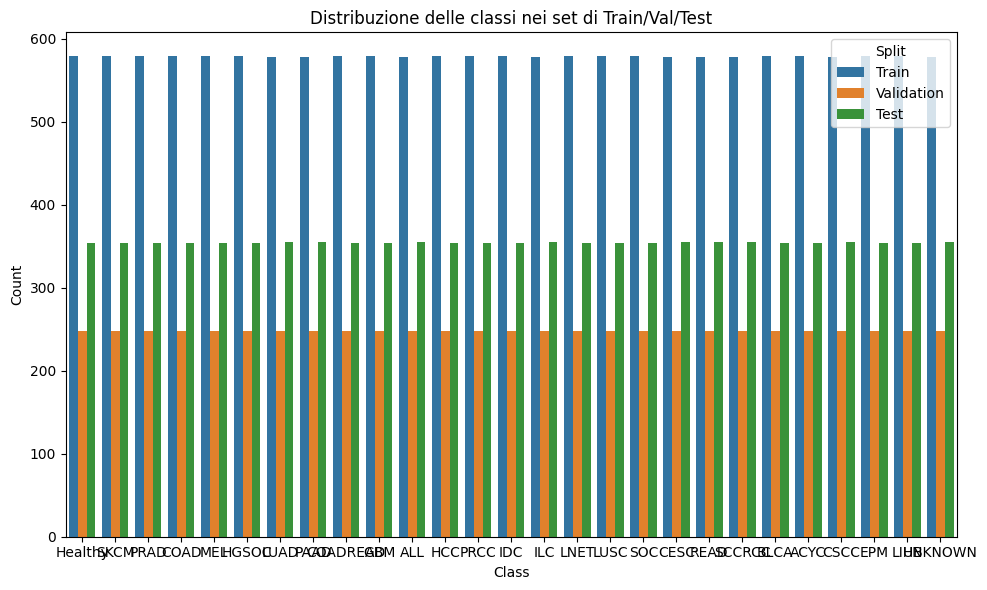

In [7]:
plot_class_distributions(train_dataset, val_dataset, test_dataset, full_dataset=dataset)

In [8]:
train_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True, num_workers=16, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=False, num_workers=16, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=False, num_workers=16, drop_last=True)

In [9]:
labels_num = len(np.unique(dataset.labels))

print(f"Number of classes: {labels_num}")
model = ViT_UCB_Pruning(model_name="hf-hub:MahmoodLab/uni", 
    pretrained=True, 
    n_classes=labels_num, 
    keep_ratio=PRUNING_RATIO,        
    exclude_cls=False
)

Number of classes: 27
Loading source model 'hf-hub:MahmoodLab/uni'...


09/05/2025 11:16:25 - INFO - timm.models._builder - Loading pretrained weights from Hugging Face hub (MahmoodLab/uni)


In [10]:
args = TrainingArguments(
        output_dir="./results",
        run_name=f"ViT-L-UCB-{PRUNING_RATIO}",
        num_train_epochs=NUM_EPOCHS,
        evaluation_strategy="epoch",
        learning_rate=0.1,
        train_batch_size=8,
        eval_batch_size=8,
        max_steps=-1,
        warmup_steps=500,
        eval_steps=5000,
        save_steps=10000,
        logging_steps=300,
        fp16=False,
        report_to="wandb", 
        early_stopping_patience=7, 
        early_stopping_metric="eval/loss", 
    )


In [11]:
optimizer = torch.optim.SGD(model.parameters(), lr=args.learning_rate, weight_decay=args.weight_decay)
# The scheduler needs max_steps, so we calculate it first
num_steps = args.num_train_epochs * (len(train_loader) // args.gradient_accumulation_steps)
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=args.warmup_steps, num_training_steps=num_steps)

In [12]:
trainer = ModelTrainer(
        model=model,
        args=args,
        train_dataloader=train_loader,
        eval_dataloader=val_loader,
        test_dataloader=test_loader,
        class_names=dataset.class_names,           # Pass the class names
        optimizers=(optimizer, scheduler),
        device= DEVICE
    )

/home/vcivale/UNI_UCB2/src/rl/train.py:97: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = GradScaler(enabled=self.args.fp16)
wandb: Currently logged in as: vincenzo-civale (vincenzo-civale-universi-degli-studi-di-firenze) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


09/05/2025 11:16:31 - INFO - src.rl.train - Monitoraggio della metrica 'eval/loss' per early stopping e/o salvataggio del modello migliore.


In [ ]:
trainer.train()

09/05/2025 11:16:31 - INFO - src.rl.train - ***** Inizio del Training *****
09/05/2025 11:16:31 - INFO - src.rl.train -   Num Epochs = 50
09/05/2025 11:16:31 - INFO - src.rl.train -   Total optimization steps = 97650
Epoch 1/50:   0%|          | 0/1953 [00:00<?, ?it/s]/home/vcivale/UNI_UCB2/src/rl/train.py:234: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=self.args.fp16):
Epoch 1/50:  78%|███████▊  | 1515/1953 [10:03<02:54,  2.52it/s, loss=1.2500, lr=1.00e-01]